In [0]:
%matplotlib inline

In [2]:
!pip install torchsummary
!pip install albumentations
from torchsummary import summary

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Common/')

In [5]:
from models import *
from utils import *
from data_loaders import *
from train import *
import validation as test
from graph import *
from albumentation import *
from albumentations import Normalize, HorizontalFlip, VerticalFlip, Rotate, Cutout
from gradCAM import *
from lr_finder import *

  pip install torch-lr-finder -v --global-option="amp"


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
BATCH_SIZE = 128
EPOCHS = 50
device = getDevice()
dataloader_args = getDataLoaderArgs(BATCH_SIZE)
train_data_transforms_list = [Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                              Cutout(num_holes=1, max_h_size=16, max_w_size = 16,p=0.5),
                              HorizontalFlip(),
                                # Rotate(limit=45)
                                ]
train_data_transfomrs = getAlbumTransformation(train_data_transforms_list)
trainloader = getTrainDataLoader("CIFAR", dataloader_args, train_data_transfomrs)
test_data_transforms_list = [Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
test_data_transfomrs = getAlbumTransformation(test_data_transforms_list)
testloader = getTestDataLoader("CIFAR", dataloader_args, test_data_transfomrs)
model = MyResNet18().to(device)
summary(model, input_size=(3, 32, 32))



CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
      


Learning rate search finished. See the graph with {finder_name}.plot()


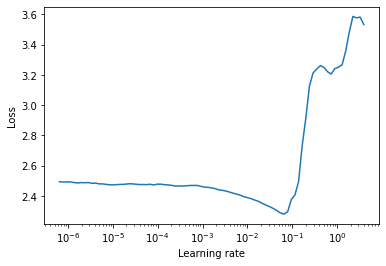

0.06579332246575682
Best Loss :  2.280957727660938


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=10, num_iter=100)
lr_finder.plot()
lr_finder.reset()
print(lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)])
print('Best Loss : ',lr_finder.best_loss)

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0.0005)
all_train_acc = []

for epoch in range(EPOCHS):
  running_loss = 0
  print('EPOCH : ', epoch)
  train(model, device, trainloader, optimizer, criterion)
  all_train_acc.append(train_acc[-1])
  test.__test(model, device, testloader, criterion)
  scheduler.step(running_loss)
  

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH :  0


Loss=1.9976345300674438 Batch_id=390 Accuracy=11.86: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 1884/10000 (18.84%)

EPOCH :  1


Loss=1.725079894065857 Batch_id=390 Accuracy=29.55: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0129, Accuracy: 3779/10000 (37.79%)

EPOCH :  2


Loss=1.2144193649291992 Batch_id=390 Accuracy=44.31: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 4843/10000 (48.43%)

EPOCH :  3


Loss=1.1459779739379883 Batch_id=390 Accuracy=56.31: 100%|██████████| 391/391 [00:33<00:00, 11.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 3529/10000 (35.29%)

EPOCH :  4


Loss=0.8018389940261841 Batch_id=390 Accuracy=62.13: 100%|██████████| 391/391 [00:33<00:00, 11.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 5115/10000 (51.15%)

EPOCH :  5


Loss=0.8923704028129578 Batch_id=390 Accuracy=64.64: 100%|██████████| 391/391 [00:33<00:00, 11.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 4210/10000 (42.10%)

EPOCH :  6


Loss=1.0575358867645264 Batch_id=390 Accuracy=66.55: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Accuracy: 5774/10000 (57.74%)

EPOCH :  7


Loss=1.1362643241882324 Batch_id=390 Accuracy=67.61: 100%|██████████| 391/391 [00:33<00:00, 11.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 6307/10000 (63.07%)

EPOCH :  8


Loss=1.0491406917572021 Batch_id=390 Accuracy=68.04: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 5517/10000 (55.17%)

EPOCH :  9


Loss=1.2860914468765259 Batch_id=390 Accuracy=68.62: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 6672/10000 (66.72%)

EPOCH :  10


Loss=0.7460587620735168 Batch_id=390 Accuracy=69.20: 100%|██████████| 391/391 [00:33<00:00, 11.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0110, Accuracy: 5830/10000 (58.30%)

EPOCH :  11


Loss=0.8906611204147339 Batch_id=390 Accuracy=69.46: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 4717/10000 (47.17%)

Epoch    12: reducing learning rate of group 0 to 5.0000e-02.
EPOCH :  12


Loss=0.5581425428390503 Batch_id=390 Accuracy=79.77: 100%|██████████| 391/391 [00:33<00:00, 11.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8375/10000 (83.75%)

EPOCH :  13


Loss=0.6096781492233276 Batch_id=390 Accuracy=83.04: 100%|██████████| 391/391 [00:33<00:00, 11.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8404/10000 (84.04%)

EPOCH :  14


Loss=0.315432608127594 Batch_id=390 Accuracy=84.48: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8301/10000 (83.01%)

EPOCH :  15


Loss=0.29418015480041504 Batch_id=390 Accuracy=84.85: 100%|██████████| 391/391 [00:33<00:00, 11.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8392/10000 (83.92%)

EPOCH :  16


Loss=0.31995895504951477 Batch_id=390 Accuracy=85.38: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8290/10000 (82.90%)

EPOCH :  17


Loss=0.4624907374382019 Batch_id=390 Accuracy=85.70: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8350/10000 (83.50%)

EPOCH :  18


Loss=0.4602355360984802 Batch_id=390 Accuracy=86.15: 100%|██████████| 391/391 [00:32<00:00, 11.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8189/10000 (81.89%)

EPOCH :  19


Loss=0.44439011812210083 Batch_id=390 Accuracy=86.27: 100%|██████████| 391/391 [00:33<00:00, 11.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8372/10000 (83.72%)

EPOCH :  20


Loss=0.3320503830909729 Batch_id=390 Accuracy=86.64: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8281/10000 (82.81%)

EPOCH :  21


Loss=0.48283109068870544 Batch_id=390 Accuracy=86.65: 100%|██████████| 391/391 [00:33<00:00, 11.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8261/10000 (82.61%)

EPOCH :  22


Loss=0.44303518533706665 Batch_id=390 Accuracy=87.03: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8447/10000 (84.47%)

Epoch    23: reducing learning rate of group 0 to 5.0000e-03.
EPOCH :  23


Loss=0.286337673664093 Batch_id=390 Accuracy=91.47: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8950/10000 (89.50%)

EPOCH :  24


Loss=0.23433609306812286 Batch_id=390 Accuracy=93.18: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8972/10000 (89.72%)

EPOCH :  25


Loss=0.17748913168907166 Batch_id=390 Accuracy=93.83: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9009/10000 (90.09%)

EPOCH :  26


Loss=0.2982860505580902 Batch_id=390 Accuracy=94.41: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9001/10000 (90.01%)

EPOCH :  27


Loss=0.17025992274284363 Batch_id=390 Accuracy=94.83: 100%|██████████| 391/391 [00:33<00:00, 11.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9002/10000 (90.02%)

EPOCH :  28


Loss=0.10449279844760895 Batch_id=390 Accuracy=95.08: 100%|██████████| 391/391 [00:33<00:00, 11.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9017/10000 (90.17%)

EPOCH :  29


Loss=0.22052237391471863 Batch_id=390 Accuracy=95.36: 100%|██████████| 391/391 [00:32<00:00, 11.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8984/10000 (89.84%)

EPOCH :  30


Loss=0.12413036823272705 Batch_id=390 Accuracy=95.83: 100%|██████████| 391/391 [00:32<00:00, 11.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9027/10000 (90.27%)

EPOCH :  31


Loss=0.09338466823101044 Batch_id=390 Accuracy=96.11: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9042/10000 (90.42%)

EPOCH :  32


Loss=0.06892714649438858 Batch_id=390 Accuracy=96.25: 100%|██████████| 391/391 [00:33<00:00, 11.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9034/10000 (90.34%)

EPOCH :  33


Loss=0.07635968178510666 Batch_id=390 Accuracy=96.43: 100%|██████████| 391/391 [00:33<00:00, 11.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9023/10000 (90.23%)

Epoch    34: reducing learning rate of group 0 to 5.0000e-04.
EPOCH :  34


Loss=0.13627122342586517 Batch_id=390 Accuracy=96.92: 100%|██████████| 391/391 [00:33<00:00, 11.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9054/10000 (90.54%)

EPOCH :  35


Loss=0.09316644072532654 Batch_id=390 Accuracy=97.10: 100%|██████████| 391/391 [00:32<00:00, 11.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9041/10000 (90.41%)

EPOCH :  36


Loss=0.10662011802196503 Batch_id=390 Accuracy=97.14: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9057/10000 (90.57%)

EPOCH :  37


Loss=0.058066077530384064 Batch_id=390 Accuracy=97.13: 100%|██████████| 391/391 [00:33<00:00, 11.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9053/10000 (90.53%)

EPOCH :  38


Loss=0.10608068853616714 Batch_id=390 Accuracy=97.31: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9058/10000 (90.58%)

EPOCH :  39


Loss=0.15455594658851624 Batch_id=390 Accuracy=97.28: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9062/10000 (90.62%)

EPOCH :  40


Loss=0.14314226806163788 Batch_id=390 Accuracy=97.31: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9049/10000 (90.49%)

EPOCH :  41


Loss=0.06886065751314163 Batch_id=390 Accuracy=97.44: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9057/10000 (90.57%)

EPOCH :  42


Loss=0.04720072075724602 Batch_id=390 Accuracy=97.46: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9053/10000 (90.53%)

EPOCH :  43


Loss=0.16435307264328003 Batch_id=390 Accuracy=97.54: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9065/10000 (90.65%)

EPOCH :  44


Loss=0.13486993312835693 Batch_id=390 Accuracy=97.32: 100%|██████████| 391/391 [00:33<00:00, 11.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9062/10000 (90.62%)

EPOCH :  45


Loss=0.08320785313844681 Batch_id=390 Accuracy=97.55: 100%|██████████| 391/391 [00:33<00:00, 11.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9065/10000 (90.65%)

EPOCH :  46


Loss=0.17090368270874023 Batch_id=390 Accuracy=97.48: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9059/10000 (90.59%)

EPOCH :  47


Loss=0.09347639232873917 Batch_id=390 Accuracy=97.58: 100%|██████████| 391/391 [00:33<00:00, 11.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9046/10000 (90.46%)

EPOCH :  48


Loss=0.04913432151079178 Batch_id=390 Accuracy=97.53: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9063/10000 (90.63%)

EPOCH :  49


Loss=0.048960160464048386 Batch_id=390 Accuracy=97.65: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]



Test set: Average loss: 0.0024, Accuracy: 9059/10000 (90.59%)



In [8]:
!mkdir savedModels
import torch
modelName = 'cifar_myresnet18'
# torch.save(model.state_dict(), "./savedModels/"+modelName+".pt")

mkdir: cannot create directory ‘savedModels’: File exists


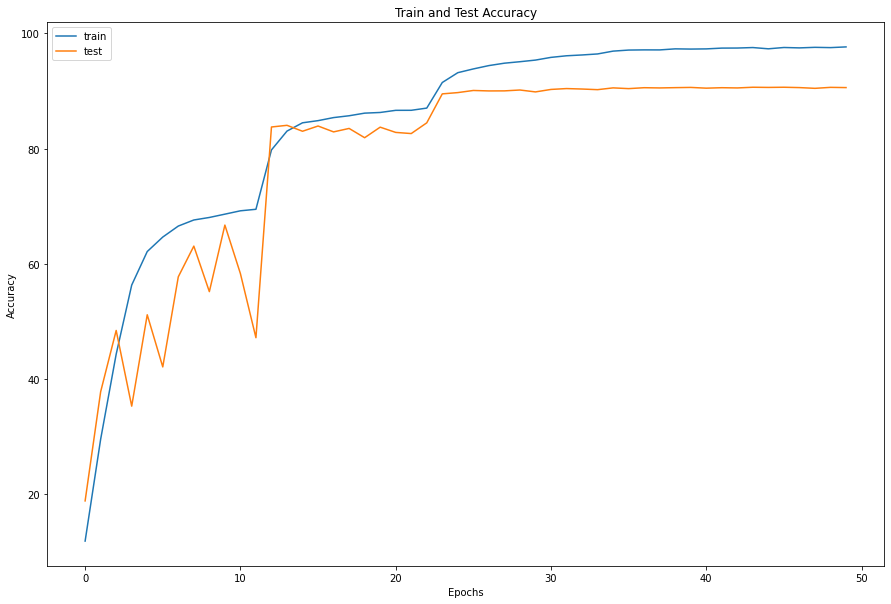

In [12]:
all_test_acc = {'train':all_train_acc,'test':test.test_acc}
plotGraph(all_test_acc, "Train and Test Accuracy","Epochs", "Accuracy")

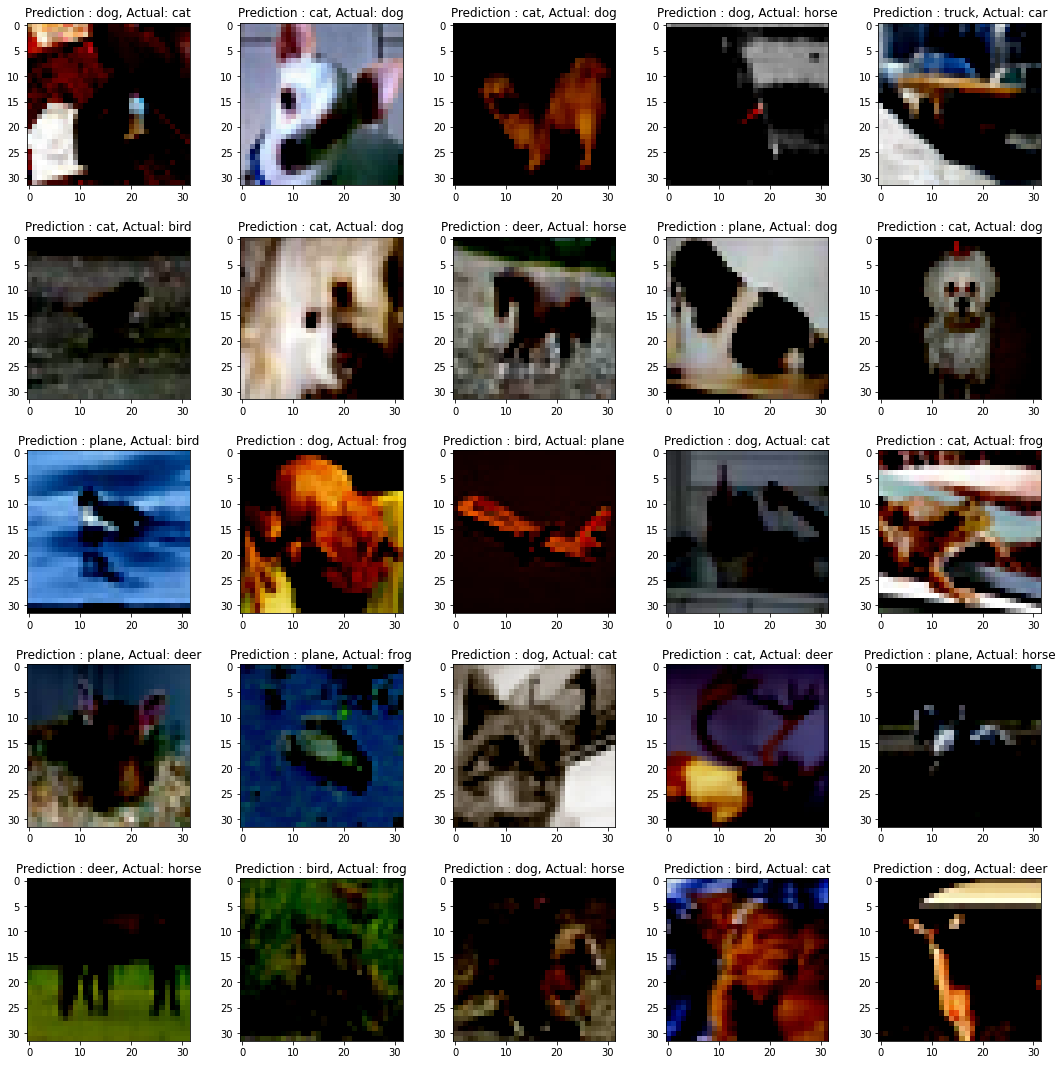

In [9]:
missClassImgs = getMisclassifiedImages(ResNet18(), testloader, device, 'savedModels/'+modelName+'.pt')
plotMisclassifiedImages(missClassImgs, classes)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


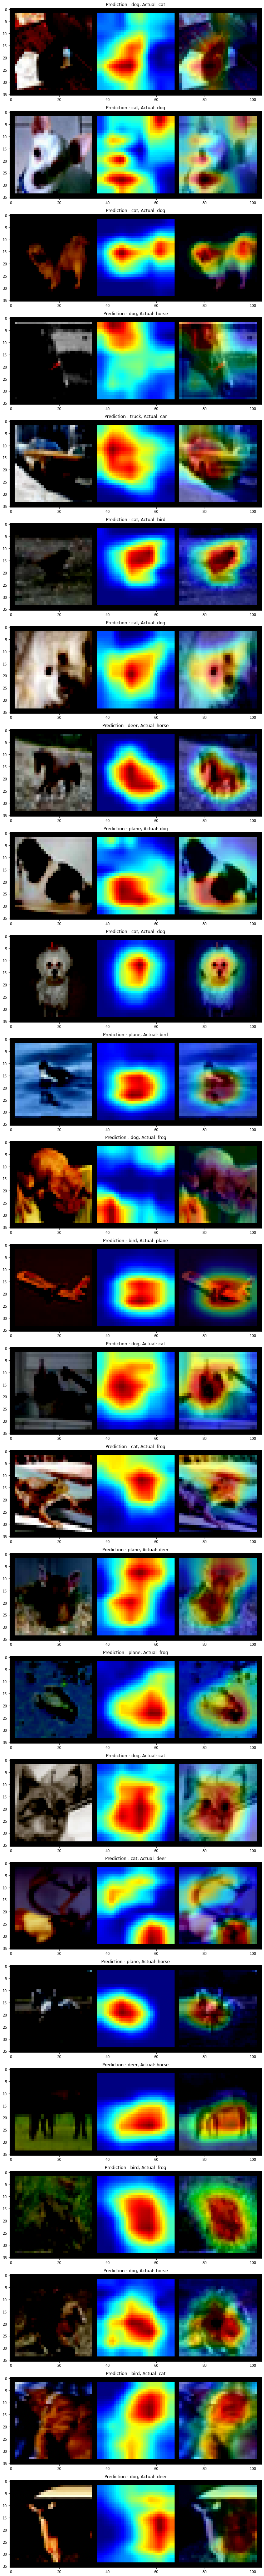

In [11]:
titles = getPredActualTitle(missClassImgs[:25], classes)
getGradCamOutput(MyResNet18(), 'resnet', 'savedModels/'+modelName+'.pt', 'layer4', missClassImgs[:25], titles)